In [790]:
import plotly.graph_objects as go
import kaleido
from IPython.display import Image
import numpy as np
import networkx as nx
import pandas as pd
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# PDF
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

PAGE_WIDTH, PAGE_HEIGHT = 8.15 * inch, 13 * inch  # 8.15" x 13"

# PATHS
CSV_PATH = './csv-files/'
IMAGE_PATH = './images/'
PDF_PATH = './pdfs/'

# FONTS
global_font = dict(
    family="Arial, sans-serif",
    size=14,
    color="black"
)

plt.rc("font", family="Arial", size=14)

pd.set_option('display.max_columns', None)

# Bar Assignment

## Visualisation of CSV file

In [791]:
bar_df = pd.read_csv(CSV_PATH + "bar_assignment.csv", sep = ",")
bar_df.head(bar_df.size)

,LABEL,COUNT
0,D,1
1,D,1
2,D,0
3,D,1
4,F,1
5,F,1
6,F,0
7,F,0
8,I,1
9,N,1


## Graph

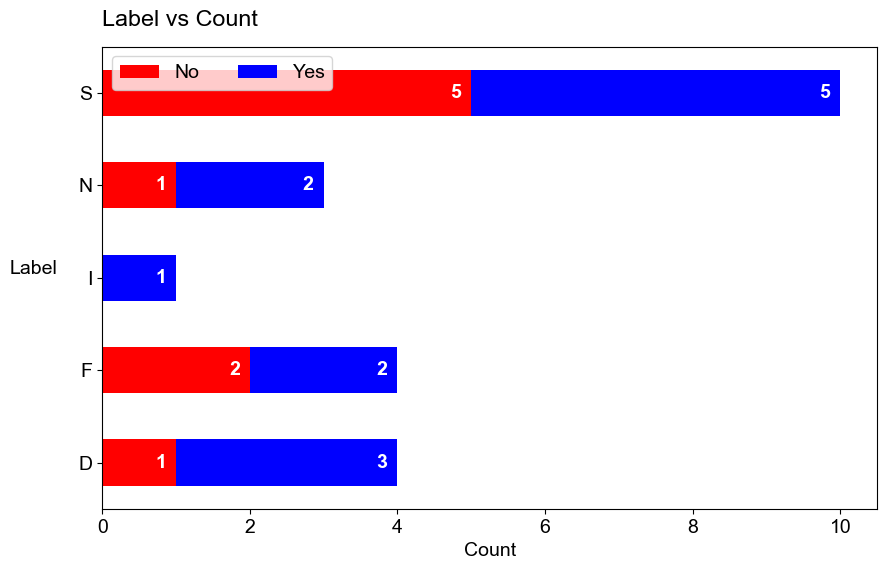

In [792]:
bar_df["COUNT"] = bar_df["COUNT"].map({1: "Yes", 0: "No"})
bar_pivot = bar_df.pivot_table(index="LABEL", columns="COUNT", aggfunc="size", fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
bars = bar_pivot.plot(kind="barh", stacked=True, ax=ax, color=['red', 'blue'])
    
for container in ax.containers:
    labels = [int(val) if val > 0 else "" for val in container.datavalues]  # Remove zero labels
    ax.bar_label(container, labels=labels, color='white', padding=-15, fontweight='bold')

# Title and labels
plt.title("Label vs Count", loc='left',pad=15)
plt.ylabel('Label', rotation=0, labelpad=32)
plt.xlabel('Count')

# Legend
plt.legend(loc='upper left', ncols=2)

# Save and show
bar_chart_path = IMAGE_PATH + "bar_graph.png"
plt.savefig(bar_chart_path, bbox_inches="tight")
plt.show()


# Sankey Assignment

## Visualization of CSV File

In [793]:
sankey_df = pd.read_csv(CSV_PATH + "sankey_assignment.csv")
sankey_df.head(sankey_df.size)

,LABEL,PS,OMP,CNP,NRP,NMCCC,PEC,NCDM,RGS,Reg,Aca,Oth
0,S,3,4,1,1,0,0,1,1,2,7,1
1,F,0,1,2,1,1,0,0,1,2,2,0
2,D,1,1,2,0,0,0,1,1,1,3,1
3,N,1,1,1,1,0,1,1,0,2,2,1
4,I,0,1,0,0,0,0,0,0,0,1,0


## Graph

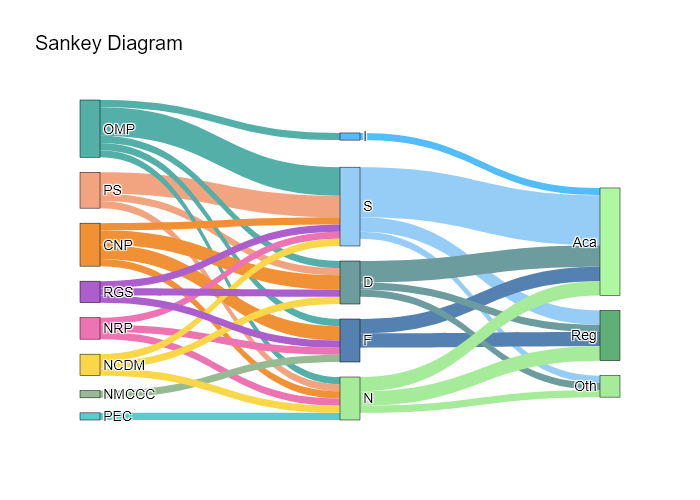

In [794]:
# Define node groups
start_nodes = list(sankey_df.columns[1:9])
middle_nodes = list(sankey_df['LABEL'].unique())
end_nodes = list(sankey_df.columns[9:])

# Combine all nodes in order (start → middle → end)
all_nodes = start_nodes + middle_nodes + end_nodes

# Map node names to indices
node_indices = {node: idx for idx, node in enumerate(all_nodes)}

# Lists to store Sankey link data
source = []
target = []
value = []

# **First Set of Links (start → middle)**
for start in start_nodes:
     for mid in middle_nodes:
            val = sankey_df.loc[sankey_df['LABEL'] == mid, start].values[0]
            if val > 0:
                source.append(node_indices[start])  # Source index
                target.append(node_indices[mid])    # Target index
                value.append(val)                   # Flow value
      

# **Second Set of Links (middle → end)**
for mid in middle_nodes:
    for end in end_nodes:
            val = sankey_df.loc[sankey_df['LABEL'] == mid, end].values[0]
            if val > 0:
                source.append(node_indices[mid])   # Source index
                target.append(node_indices[end])   # Target index
                value.append(val)                  # Flow value
               
label_colors = [
    '#F2A481', # PS
    '#54AFA9', # OMP
    '#F09135', # CNP
    '#ED74B2', # NRP
    '#98BA93', # NMCCC
    '#5CCBCF', # PEC
    '#F9D749', # NCDM
    '#AD5ECD', # RGS
    '#96CDF6', # S
    '#5481B0', # F
    '#6D9C9F', # D
    '#A6EB99', # N 
    '#53BDF9', # I
    '#5FB076', # Reg
    '#AFF8A2', # Aca
    '#A6EB99' # Oth
]

# Create Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = all_nodes,
      color = label_colors,
    ),
    link = dict(
        source = source,
        target = target, 
        value = value,
        color = [label_colors[s] for s in source]
  ))])

# Set title
fig.update_layout(title_text="Sankey Diagram", font=global_font)

# **Save as Image**
fig.write_image(IMAGE_PATH + "sankey_diagram.png")  # Saves as PNG
# fig.show()  # Displays the diagram

Image(IMAGE_PATH + "sankey_diagram.png")

# Network Assignment

## Visualization of CSV File

In [795]:
network_df = pd.read_csv(CSV_PATH + "networks_assignment.csv")
network_df.head(network_df.size)

,LABELS,N,D,F,I,S,AUT,BEL,BIH,BGR,HRV,CZE,EST,FRA,GEO,DEU,GRC,HUN,IRL,ISR,ITA,LVA,LUX,MNE,NLD,PRT,ROU,SRB,SVK,SVN,ESP,CHE,TUR,UKR,GBR,AUS,HKG,ASU
0,D,3,0,3,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,1
1,F,1,2,0,1,1,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,1,0,0,2,1,1,0,1,1,2,1,0,0,2,0,0,0
2,I,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,N,0,2,2,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,2,1,0,1
4,S,5,4,3,3,0,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,4,2,2,2,0,0,2,2,2,2,3,1,1,1


## Graph

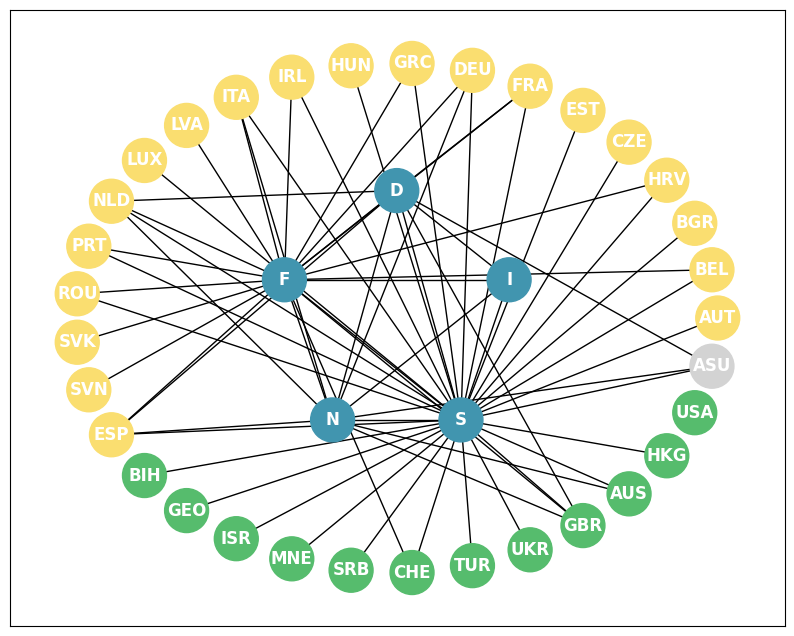

In [796]:
# Nodes
blue_nodes = ['D' ,'F', 'I', 'N', 'S']
green_nodes = ['BIH', 'GEO', 'ISR', 'MNE', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'AUS', 'HKG', 'USA']
yellow_nodes = ['AUT', 'BEL', 'BGR', 'HRV', 'CZE', 'EST', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LUX', 'NLD', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP']

# Start with predefined node groups
nodes = blue_nodes + yellow_nodes + green_nodes

# Add any nodes from the CSV that aren't already included. To sort the nodes
for node in network_df.columns:
    if node != "LABELS" and node not in nodes:
        nodes.append(node)

# Edge List
edges = []

# Temporary lists to store edges by category
blue_edges = []
green_edges = []
yellow_edges = []
other_edges = []

for i, row in network_df.iterrows():
    source = row["LABELS"]
    for target, weight in row.iloc[1:].items():
        if weight > 0:  # Only keep actual edges
            if source in blue_nodes and target in blue_nodes:
                blue_edges.append((source, target))
            elif source in green_nodes and target in green_nodes:
                green_edges.append((source, target))
            elif source in yellow_nodes and target in yellow_nodes:
                yellow_edges.append((source, target))
            else:
                other_edges.append((source, target))  # Unclassified edges

# Append edges in the correct order
edges = blue_edges + green_edges + yellow_edges + other_edges

G = nx.Graph()

G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Get all nodes that are NOT in blue_nodes
non_blue_nodes = [node for node in G.nodes if node not in blue_nodes]

# Apply circular layout to only the non-blue nodes
pos = nx.circular_layout(G.subgraph(non_blue_nodes), center=(0, 0), scale=1.0)

pos.update({
    'D': np.array([0, 0.5]),
    'F': np.array([-0.35, 0.15]),
    'I': np.array([0.35, 0.15]),
    'N': np.array([-0.20, -0.4]),
    'S': np.array([0.20, -0.4])
})

colors = [
    '#4195AF' if node in blue_nodes else 
    '#56BC6D' if node in green_nodes else 
    '#FADE70' if node in yellow_nodes else 
    'lightgray'
    for node in nodes
]

plt.figure(figsize=(10, 8))

# Draw graph
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=1000)
nx.draw_networkx_labels(G, pos, font_weight='bold', font_color='white')
nx.draw_networkx_edges(G, pos, arrows=False, edge_color='black')

# Save image to IMAGE_PATH
plt.savefig(IMAGE_PATH + 'network_graph.png', bbox_inches="tight")
plt.show()

# Collated Graphs

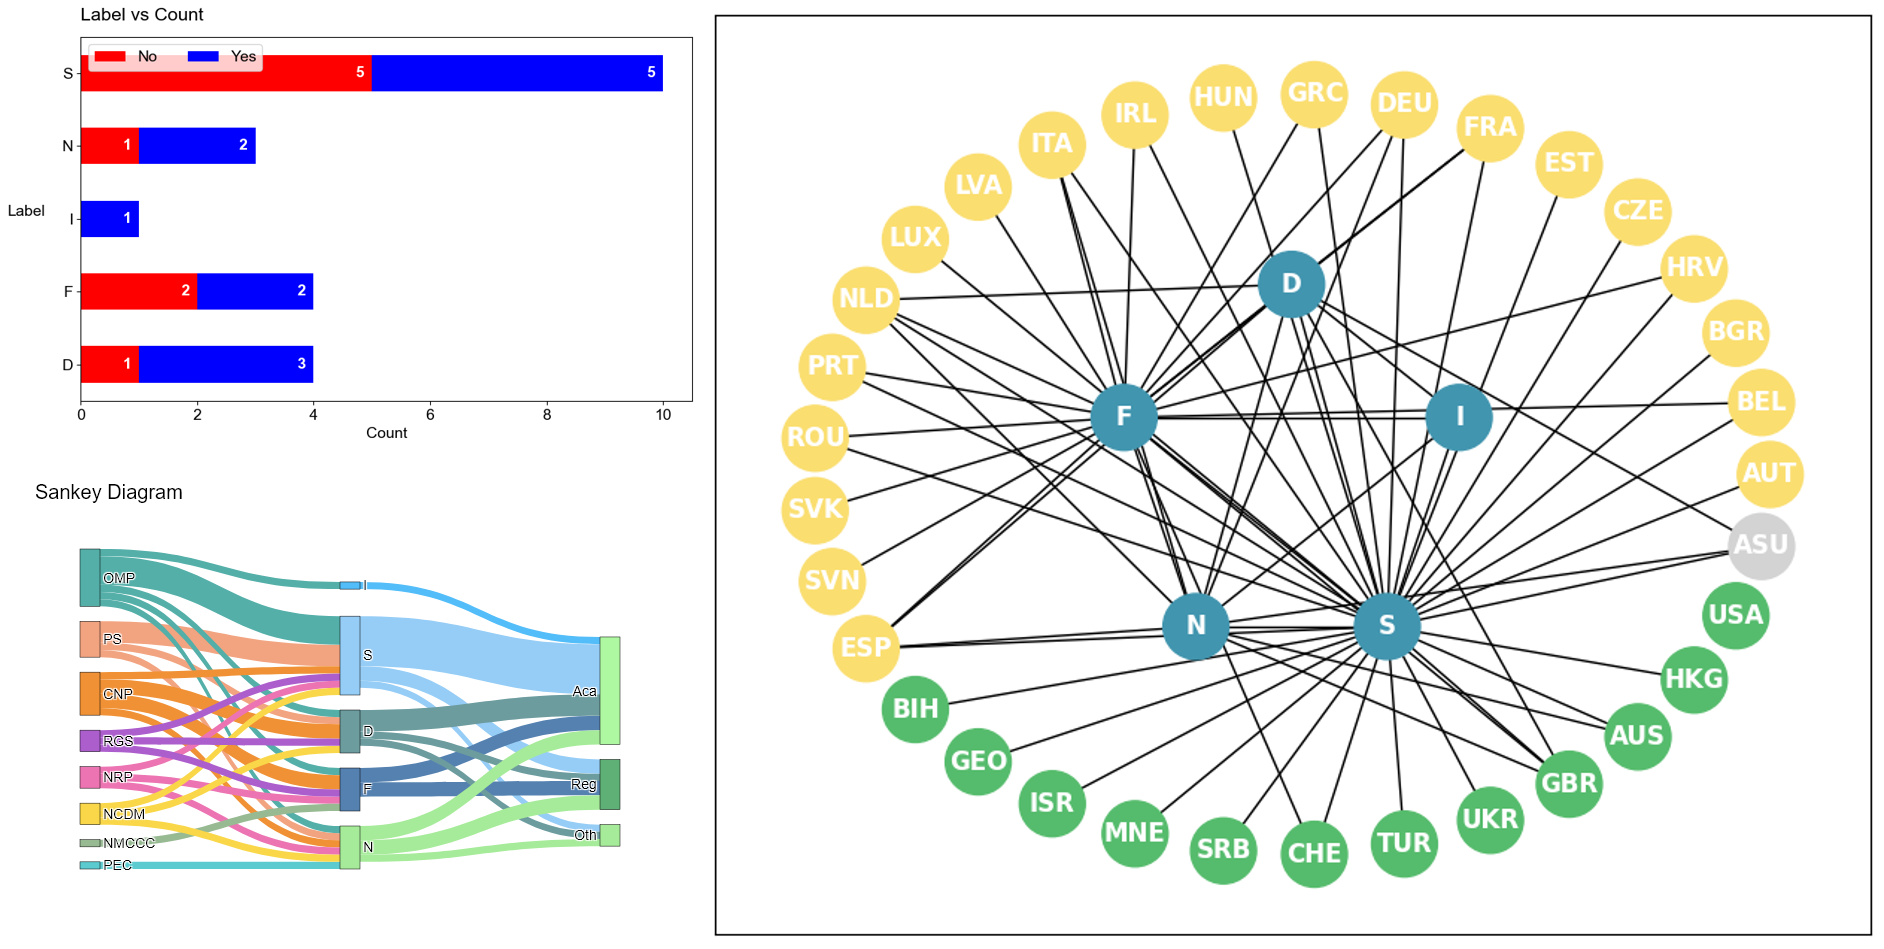

In [797]:
def collate_images(bar_chart, sankey, network_plot, img_output, pdf_output):
    # Open images
    img1 = PILImage.open(bar_chart)  # Bar Chart
    img2 = PILImage.open(sankey)  # Sankey
    img3 = PILImage.open(network_plot)  # Network Plot

    # Set left column width (keep the width of the narrower image)
    left_width = min(img1.width, img2.width)

    # Resize both left images while maintaining aspect ratio
    img1_ratio = img1.height / img1.width
    img2_ratio = img2.height / img2.width

    img1_new_height = int(left_width * img1_ratio)
    img2_new_height = int(left_width * img2_ratio)

    img1 = img1.resize((left_width, img1_new_height))  
    img2 = img2.resize((left_width, img2_new_height))  

    # Set final canvas dimensions
    total_height = img1_new_height + img2_new_height
    right_width = img3.width * (total_height / img3.height)
    img3 = img3.resize((int(right_width), total_height))

    # Create blank canvas
    final_width = left_width + img3.width
    new_img = PILImage.new("RGB", (final_width, total_height), "white")

    # Paste images
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (0, img1_new_height))
    new_img.paste(img3, (left_width, 0))

    # Save and display
    new_img.save(img_output)
    display(Image(filename=img_output))
    
    # PDF 
    pdf = canvas.Canvas(pdf_output, pagesize=(PAGE_WIDTH, PAGE_HEIGHT))

     # Get the collated image dimensions
    img_width, img_height = new_img.size

    # Calculate scaling to fit within the page while maintaining aspect ratio
    scale = min((PAGE_WIDTH - 2 * inch) / img_width, (PAGE_HEIGHT - 2 * inch) / img_height)

    new_width = img_width * scale
    new_height = img_height * scale

    # Center image on the page
    x_offset = (PAGE_WIDTH - new_width) / 2
    y_offset = PAGE_HEIGHT - new_height - inch # (PAGE_HEIGHT - new_height) / 2

    # Convert image to ImageReader (No need to save resized image)
    img_reader = ImageReader(new_img)

    # Draw image directly into PDF
    pdf.drawImage(img_reader, x_offset, y_offset, width=new_width, height=new_height)

    # Save PDF
    pdf.save()

collate_images(IMAGE_PATH + "bar_graph.png", IMAGE_PATH + "sankey_diagram.png", IMAGE_PATH + "network_graph.png", IMAGE_PATH + "collated_graph.png", PDF_PATH + "collated_doc.pdf")